# Pymob quickstart

This super-quick quickstart gives an introduction to the basic Pymob workflow and key functionalities.  
For this, we will investigate a simple linear regression model, which we want to fit to a noisy dataset.  
Pymob supports our modeling process by providing several tools for *structuring our data*, for the *parameter estimation* and *visualization of the results*.  
  
Before starting the modeling process, we let's have a look at the main steps and modules of pymob:

1. __Simulation:__   
First, we need to initialize a Simulation object by calling the {class}`pymob.simulation.SimulationBase` class from the simulation module.   
Optionally, we can configure the simulation with `sim.config.case_study.name = "linear-regression"`, `sim.config.case_study.scenario = "test"` and many more options. 

2. __Model:__   
Our model will be defined as a python function.  
We will then assign it to our Simulation object by `.model` 

3. __Observations:__   
Our observation data needs to be structured as a [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).  
We assign it to our Simulation object by  `.observations.`  
`sim.config.data_structure` will give us some information about the layout of our data.

4. __Solver:__  
Solvers are needed to solve the model. 
In our simple case, we will use the solver "solve_analytic_1d" from the "pymob.solver.analytic module.
We  assign it to our Simulation object by `.solver` 
For more complex models, the JaxSolver from the diffrax module is a more powerful option.  
User can also implement their own solver as a subclass of `pymob.solver.SolverBase`. 
  
5. __Inferer:__  
The inferer serves as the parameter estimator.  
Pymob provided [various backends](https://pymob.readthedocs.io/en/stable/user_guide/framework_overview.html). In our example, we will work with *numpyro*.  
We assign the inferer to our Simulation object by `.inferer` and configurate the kernel we want to use (here *nuts*).  
But before, we need to parameterize our model using the *Param* class. The parameters can be marked as free or fixed, depending on whether they should be variable during an optimization procedure.  
We assign the parameters to our Simulation object by `sim.model_parameters`. This is a dictionary that holds the model input data. The keys it takes by default are `parameters`, `y0` and `x_in`. 

7. __Evaluator:__  
The Evaluator is an instance to evaluate a model. 

6. __Config:__  
Our settings will be saved in a configuration file `.cfg`.  
The config file contains information about our simulation in different sections. -> Learn more [here](https://pymob.readthedocs.io/en/stable/user_guide/case_studies.html#configuration).
We can further use it to create new Simulations by loading the settings from a config file. 


![framework-overview](.\figures\pymob_overview.png)

In [1]:
# First, import the necessary python packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Import the pymob modules
from pymob.simulation import SimulationBase
from pymob.sim.solvetools import solve_analytic_1d
from pymob.sim.config import Param

Since no measured data is provided, we will generate an artificial dataset.  
$y_{obs}$ represents the observation data over the time $t$ [0, 10].  
In order to use the data later, we need to convert it into a xarray-Dataset.  
In your application later, you would use your measuered experimental data.  

<xarray.Dataset>
Dimensions:  (t: 100)
Coordinates:
  * t        (t) float64 0.0 0.101 0.202 0.303 0.404 ... 9.697 9.798 9.899 10.0
Data variables:
    y        (t) float64 2.22 -0.3948 1.384 0.7673 ... 32.87 35.55 32.99 33.12

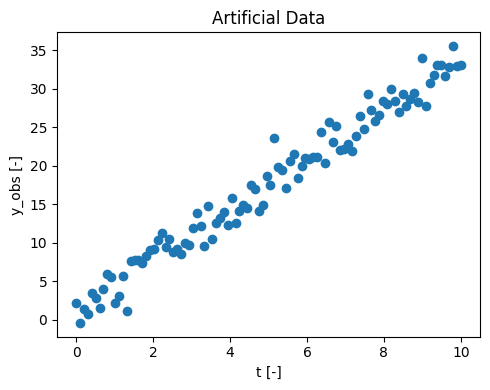

In [2]:
# Parameter for the artificial data generation
slope = np.random.uniform(2.0, 4.0) 
intercept = 1.0
num_points = 100
noise_level = 1.7

# generating time values
t = np.linspace(0, 10, num_points)

# generating y-values with noise
noise = np.random.normal(0, noise_level, num_points)
y_obs = slope * t + intercept + noise

# visualizing our data
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(t, y_obs, label='Datapoints')
ax.set(xlabel='t [-]', ylabel='y_obs [-]', title ='Artificial Data')
plt.tight_layout()

# convert the data to an xr-Dataset
data_obs = xr.DataArray(y_obs, coords={"t": t}).to_dataset(name="y")
data_obs



## Initialize a simulation

In pymob a Simulation object is initialized by calling the {class}`pymob.simulation.SimulationBase` class from the simulation module.  
We will chose a linear regression model, since it seems to be a good approximation to the data.

```{admonition} x-dimension
:class: note
The x_dimension of our simulation can have any name, for expample t as often used for time series data.
You can specified it via `sim.config.simulation.x_dimension`.
```

In [3]:
# Initialize the Simulation object
sim = SimulationBase()

# Define the linear regression model
def linreg(x, a, b):
    return a + x * b

# Add the model to the simulation
sim.model = linreg

# Adding our dataset to the simulation
sim.observations = data_obs

# Defining a solver
sim.solver = solve_analytic_1d

MinMaxScaler(variable=y, min=-0.39481712290701676, max=35.554126963859574)


C:\Users\mgrho\pymob\pymob\simulation.py:303: UserWarning: `sim.config.data_structure.y = Datavariable(dimensions=['t'] min=-0.39481712290701676 max=35.554126963859574 observed=True dimensions_evaluator=None)` has been assumed from `sim.observations`. If the order of the dimensions should be different, specify `sim.config.data_structure.y = DataVariable(dimensions=[...], ...)` manually.
  warnings.warn(


```{admonition} Scalers
:class: note
We notice a mysterious Scaler message. This tells us that our data variable has been identified and a scaler was constructed, which transforms the variable between [0, 1].   
This has no effect at the moment, but it can be used later. Scaling can be powerful to help parameter estimation in more complex models.
```


## Running the model 🏃

Next, we define the model parameters *a* and *b*.  
The parameter *a* is set as fixed (`free = False`), meaning its value is known and will not be estimated during optimization.  
The parameter *b* is marked as free (`free = True`), allowing it to be optimized to fit our data. As an initial guess, we assume b = 3.   

Our model is now prepared with a parameter set.  
In order to intialize the *Evaluator* class, we need to execute `sim.dispatch_constructor()`.   
This step is very important and needs to be done everytime when we made changes in our model.  

The returned dataset (`evaluator.results`) has the exact same shape as our observation data.

In [ ]:
# Parameterizing the model
sim.config.model_parameters.a = Param(value=1, free=False)
sim.config.model_parameters.b = Param(value=3, free=True)
# this makes sure the model parameters are available to the model.
sim.model_parameters["parameters"] = sim.config.model_parameters.value_dict

# put everything in place for running the simulation
sim.dispatch_constructor()

# run
evaluator = sim.dispatch(theta={"b":3})
evaluator()
evaluator.results

C:\Users\mgrho\pymob\pymob\simulation.py:552: UserWarning: The number of ODE states was not specified in the config file [simulation] > 'n_ode_states = <n>'. Extracted the return arguments ['a+x*b'] from the source code. Setting 'n_ode_states=1.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (t: 100)
Coordinates:
  * t        (t) float64 0.0 0.101 0.202 0.303 0.404 ... 9.697 9.798 9.899 10.0
Data variables:
    y        (t) float64 1.0 1.303 1.606 1.909 2.212 ... 30.09 30.39 30.7 31.0

Let's have a look at the results.  
You can vary the parameter *b* in the previous step to investigate it's influence on the model fit.   

In the [beginner guide](), you can try out the *manual parameter estimation*, which is provided by Pymob.

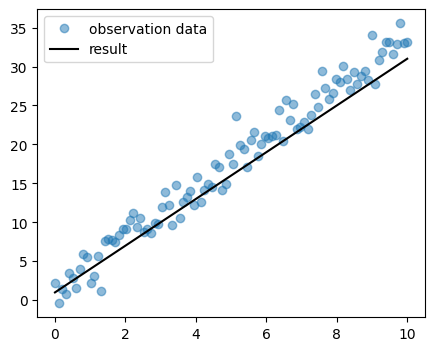

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))
data_res = evaluator.results
ax.plot(data_obs.t, data_obs.y, ls="", marker="o", color="tab:blue", alpha=.5, label ="observation data")
ax.plot(data_res.t, data_res.y, color="black", label ="result")
ax.legend()

## Estimating parameters 

We are almost set infer the parameters of the model. We add another parameter to also estimate the error of the parameters, We use a lognormal distribution for it. We also specify an error model for the distribution. This will be 

$$y_{obs} \sim Normal (y, \sigma_y)$$

Jax 64 bit mode: False
Absolute tolerance: 1e-07


C:\Users\mgrho\pymob\pymob\inference\numpyro_backend.py:552: UserWarning: Model is not rendered, because the graphviz executable is not found. Try search for 'graphviz executables not found' and the used OS. This should be an easy fix :-)
  warnings.warn(


Trace Shapes:      
 Param Sites:      
Sample Sites:      
       b dist     |
        value     |
 sigma_y dist     |
        value     |
   y_obs dist 100 |
        value 100 |


sample: 100%|██████████| 3000/3000 [00:04<00:00, 639.77it/s, 3 steps of size 8.64e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.30      0.03      3.30      3.26      3.35   1785.61      1.00
   sigma_y      1.69      0.12      1.68      1.50      1.90   1189.45      1.00

Number of divergences: 0


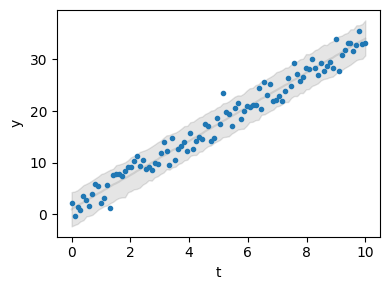

In [6]:
sim.config.model_parameters.sigma_y = Param(free=True , prior="lognorm(scale=1,s=1)", min=0, max=1)
sim.config.model_parameters.b.prior = "lognorm(scale=1,s=1)"
sim.config.model_parameters.b.min = -5
sim.config.model_parameters.b.max = 5

sim.config.error_model.y = "normal(loc=y,scale=sigma_y)"


sim.set_inferer("numpyro")
sim.inferer.config.inference_numpyro.kernel = "nuts"
sim.inferer.run()

sim.inferer.idata.posterior

# Plot the results
sim.config.simulation.x_dimension = "t"
sim.posterior_predictive_checks(pred_hdi_style={"alpha": 0.1})

### Estimating parameters and uncertainty with MCMC

Of course this example is very simple, we can in fact optimize the parameters perfectly by hand. But just for the fun of it, let's use *Markov Chain Monte Carlo* (MCMC) to estimate the parameters, their uncertainty and the uncertainty in the data.

```{admonition} numpyro distributions
:class: warning
Currently only few distributions are implemented in the numpyro backend. This API will soon change, so that basically any distribution can be used to specifcy parameters. 
```

Finally, we let our inferer run the paramter estimation procedure with the numpyro backend and a NUTS kernel. This does the job in a few seconds

We can inspect our estimates and see that the parameters are well esimtated by the model. Note that we only get an estimate for $b$. This is because earlier we set the parameter `a` with the flag `free=False` this effectively excludes it from estimation and uses the default value, which was set to the true value `a=0`.


```{admonition} Customize the posterior predictive checks
:class: hint
You can explore the API of {class}`pymob.sim.plot.SimulationPlot` to find out how you can work on the default predictions. Of course you can always make your own plot, by accessing {attr}`pymob.simulation.inferer.idata` and {attr}`pymob.simulation.observations`
```

### Report the results

```{admonition} numpyro distributions
:class: warning
Automated reporting is already implemented in a different branch. This will be soon explained here.
```

In [7]:
# TODO: Call report when done


## Exporting the simulation and running it via the case study API

After constructing the simulation, all settings of the simulation can be exported to a comprehensive configuration file, along with all the default settings. This is as simple as 

In [8]:
import os
sim.config.case_study.name = "quickstart"
sim.config.case_study.scenario = "test"
sim.config.create_directory("scenario", force=True)
sim.config.create_directory("results", force=True)

# usually we expect to have a data directory in the case
os.makedirs(sim.data_path, exist_ok=True)
sim.save_observations(force=True)
sim.config.save(force=True)

Scenario directory exists at 'c:\Users\mgrho\pymob\docs\source\user_guide\case_studies\quickstart\scenarios\test'.
Results directory exists at 'c:\Users\mgrho\pymob\docs\source\user_guide\case_studies\quickstart\results\test'.


The simulation will be saved to the default path (`CASE_STUDY/scenarios/SCENARIO/settings.cfg`) or to a custom path spcified with the `fp` keyword. `force=True` will overwrite any existing config file, which is the reasonable choice in most cases.

From there on, the simulation is (almost) ready to be executable from the commandline.

### Commandline API

The commandline API runs a series of commands that load the case study, execute the {meth}`pymob.simulation.SimulationBase.initialize` method and perform some more initialization tasks, before running the required job.

+ `pymob-infer`: Runs an inference job e.g. `pymob-infer --case_study=quickstart --scenario=test --inference_backend=numpyro`. While there are more commandline options, these are the two required 